In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [4]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [5]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [6]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [7]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [8]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 gloss:0.6815 dlossA:0.7856 dlossQ:0.6694 exploreP:0.9983
Episode:1 meanR:34.0000 R:51.0000 rate:0.1020 gloss:0.7154 dlossA:0.7939 dlossQ:0.6829 exploreP:0.9933
Episode:2 meanR:26.0000 R:10.0000 rate:0.0200 gloss:0.6844 dlossA:0.7841 dlossQ:0.6741 exploreP:0.9923
Episode:3 meanR:22.7500 R:13.0000 rate:0.0260 gloss:0.7096 dlossA:0.7943 dlossQ:0.6791 exploreP:0.9910
Episode:4 meanR:22.8000 R:23.0000 rate:0.0460 gloss:0.7198 dlossA:0.7945 dlossQ:0.6855 exploreP:0.9888
Episode:5 meanR:22.5000 R:21.0000 rate:0.0420 gloss:0.7105 dlossA:0.7914 dlossQ:0.6828 exploreP:0.9867
Episode:6 meanR:21.4286 R:15.0000 rate:0.0300 gloss:0.6818 dlossA:0.7857 dlossQ:0.6809 exploreP:0.9853
Episode:7 meanR:20.8750 R:17.0000 rate:0.0340 gloss:0.7159 dlossA:0.7931 dlossQ:0.6861 exploreP:0.9836
Episode:8 meanR:19.8889 R:12.0000 rate:0.0240 gloss:0.6877 dlossA:0.7921 dlossQ:0.6804 exploreP:0.9824
Episode:9 meanR:21.6000 R:37.0000 rate:0.0740 gloss:0.7107 dlossA:0.7934 

Episode:79 meanR:29.8250 R:72.0000 rate:0.1440 gloss:0.6647 dlossA:0.7727 dlossQ:0.6943 exploreP:0.7899
Episode:80 meanR:29.6049 R:12.0000 rate:0.0240 gloss:0.6705 dlossA:0.7751 dlossQ:0.6919 exploreP:0.7889
Episode:81 meanR:29.7317 R:40.0000 rate:0.0800 gloss:0.6715 dlossA:0.7738 dlossQ:0.6982 exploreP:0.7858
Episode:82 meanR:30.2410 R:72.0000 rate:0.1440 gloss:0.6676 dlossA:0.7742 dlossQ:0.6991 exploreP:0.7802
Episode:83 meanR:30.1071 R:19.0000 rate:0.0380 gloss:0.6632 dlossA:0.7684 dlossQ:0.7039 exploreP:0.7788
Episode:84 meanR:30.9882 R:105.0000 rate:0.2100 gloss:0.6649 dlossA:0.7707 dlossQ:0.6986 exploreP:0.7708
Episode:85 meanR:30.8140 R:16.0000 rate:0.0320 gloss:0.6347 dlossA:0.7649 dlossQ:0.6769 exploreP:0.7695
Episode:86 meanR:31.0460 R:51.0000 rate:0.1020 gloss:0.6690 dlossA:0.7716 dlossQ:0.7039 exploreP:0.7657
Episode:87 meanR:31.1136 R:37.0000 rate:0.0740 gloss:0.6544 dlossA:0.7649 dlossQ:0.6991 exploreP:0.7629
Episode:88 meanR:31.1236 R:32.0000 rate:0.0640 gloss:0.6650 dlo

Episode:158 meanR:51.4000 R:33.0000 rate:0.0660 gloss:0.7309 dlossA:0.7743 dlossQ:0.8143 exploreP:0.5127
Episode:159 meanR:51.2700 R:22.0000 rate:0.0440 gloss:0.7303 dlossA:0.7743 dlossQ:0.8166 exploreP:0.5116
Episode:160 meanR:51.8300 R:76.0000 rate:0.1520 gloss:0.7346 dlossA:0.7760 dlossQ:0.8152 exploreP:0.5078
Episode:161 meanR:52.4700 R:116.0000 rate:0.2320 gloss:0.7349 dlossA:0.7755 dlossQ:0.8186 exploreP:0.5021
Episode:162 meanR:52.3100 R:25.0000 rate:0.0500 gloss:0.7284 dlossA:0.7745 dlossQ:0.8187 exploreP:0.5008
Episode:163 meanR:52.9400 R:89.0000 rate:0.1780 gloss:0.7355 dlossA:0.7766 dlossQ:0.8212 exploreP:0.4965
Episode:164 meanR:53.9300 R:143.0000 rate:0.2860 gloss:0.7446 dlossA:0.7782 dlossQ:0.8251 exploreP:0.4896
Episode:165 meanR:53.8900 R:42.0000 rate:0.0840 gloss:0.7364 dlossA:0.7760 dlossQ:0.8234 exploreP:0.4876
Episode:166 meanR:54.4600 R:82.0000 rate:0.1640 gloss:0.7450 dlossA:0.7796 dlossQ:0.8234 exploreP:0.4837
Episode:167 meanR:55.1700 R:123.0000 rate:0.2460 glos

Episode:236 meanR:136.9600 R:229.0000 rate:0.4580 gloss:0.9623 dlossA:0.8838 dlossQ:0.9680 exploreP:0.1588
Episode:237 meanR:137.6500 R:111.0000 rate:0.2220 gloss:0.9508 dlossA:0.8606 dlossQ:0.9650 exploreP:0.1572
Episode:238 meanR:139.6300 R:222.0000 rate:0.4440 gloss:0.9716 dlossA:0.8787 dlossQ:0.9724 exploreP:0.1540
Episode:239 meanR:141.6800 R:302.0000 rate:0.6040 gloss:0.9857 dlossA:0.8853 dlossQ:0.9795 exploreP:0.1497
Episode:240 meanR:143.8900 R:245.0000 rate:0.4900 gloss:0.9891 dlossA:0.8904 dlossQ:0.9804 exploreP:0.1463
Episode:241 meanR:143.7300 R:138.0000 rate:0.2760 gloss:1.0024 dlossA:0.9057 dlossQ:0.9832 exploreP:0.1444
Episode:242 meanR:144.1000 R:134.0000 rate:0.2680 gloss:1.0034 dlossA:0.8946 dlossQ:0.9858 exploreP:0.1426
Episode:243 meanR:144.4800 R:143.0000 rate:0.2860 gloss:1.0243 dlossA:0.9102 dlossQ:0.9821 exploreP:0.1408
Episode:244 meanR:145.1900 R:133.0000 rate:0.2660 gloss:1.0273 dlossA:0.9108 dlossQ:0.9899 exploreP:0.1390
Episode:245 meanR:146.0700 R:153.0000

Episode:313 meanR:259.4200 R:300.0000 rate:0.6000 gloss:2.5693 dlossA:2.1419 dlossQ:1.0709 exploreP:0.0281
Episode:314 meanR:263.1500 R:500.0000 rate:1.0000 gloss:2.6370 dlossA:2.1580 dlossQ:1.0551 exploreP:0.0272
Episode:315 meanR:264.2300 R:500.0000 rate:1.0000 gloss:2.6982 dlossA:2.2132 dlossQ:1.0553 exploreP:0.0264
Episode:316 meanR:264.4000 R:157.0000 rate:0.3140 gloss:2.7734 dlossA:2.2045 dlossQ:1.0562 exploreP:0.0261
Episode:317 meanR:265.2000 R:250.0000 rate:0.5000 gloss:2.7832 dlossA:2.2480 dlossQ:1.0451 exploreP:0.0257
Episode:318 meanR:267.6100 R:400.0000 rate:0.8000 gloss:2.8620 dlossA:2.2746 dlossQ:1.0806 exploreP:0.0251
Episode:319 meanR:270.6100 R:410.0000 rate:0.8200 gloss:2.9048 dlossA:2.3052 dlossQ:1.0684 exploreP:0.0245
Episode:320 meanR:272.3600 R:356.0000 rate:0.7120 gloss:3.0088 dlossA:2.4142 dlossQ:1.0658 exploreP:0.0240
Episode:321 meanR:274.8400 R:398.0000 rate:0.7960 gloss:3.1009 dlossA:2.5365 dlossQ:1.0955 exploreP:0.0235
Episode:322 meanR:274.9500 R:187.0000

Episode:390 meanR:384.3800 R:174.0000 rate:0.3480 gloss:12.3253 dlossA:9.1634 dlossQ:4.9045 exploreP:0.0109
Episode:391 meanR:384.3800 R:500.0000 rate:1.0000 gloss:12.2328 dlossA:8.4918 dlossQ:5.7661 exploreP:0.0108
Episode:392 meanR:384.3800 R:500.0000 rate:1.0000 gloss:12.1178 dlossA:8.2840 dlossQ:4.5521 exploreP:0.0108
Episode:393 meanR:387.1700 R:500.0000 rate:1.0000 gloss:12.2642 dlossA:8.2356 dlossQ:6.4383 exploreP:0.0107
Episode:394 meanR:390.5700 R:500.0000 rate:1.0000 gloss:12.2093 dlossA:7.9409 dlossQ:5.4803 exploreP:0.0107
Episode:395 meanR:390.5700 R:500.0000 rate:1.0000 gloss:12.1680 dlossA:7.5868 dlossQ:4.6129 exploreP:0.0107
Episode:396 meanR:394.0500 R:500.0000 rate:1.0000 gloss:12.4676 dlossA:8.3361 dlossQ:4.9494 exploreP:0.0106
Episode:397 meanR:396.7700 R:500.0000 rate:1.0000 gloss:12.8222 dlossA:8.2888 dlossQ:5.2978 exploreP:0.0106
Episode:398 meanR:400.8500 R:500.0000 rate:1.0000 gloss:13.1581 dlossA:8.6053 dlossQ:5.3148 exploreP:0.0106
Episode:399 meanR:400.8500 R

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

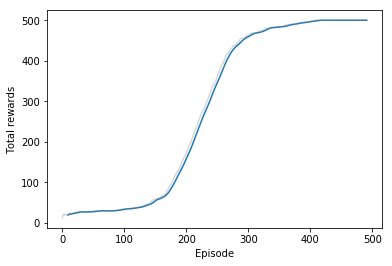

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

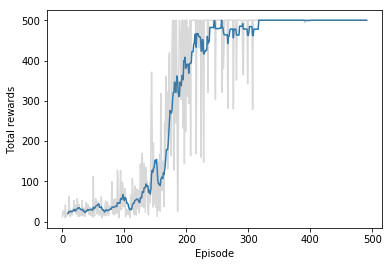

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.